# Text-summarizer

## Libraries

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

from tensorflow.keras.callbacks import EarlyStopping
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

2024-12-15 18:07:45.983239: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 18:07:45.992388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734282466.001651    9408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734282466.004336    9408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 18:07:46.015120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

data = pd.read_csv(f"{path}/Reviews.csv", nrows=100000)  # reading only 100k rows

data.drop_duplicates(subset=["Text"], inplace=True)  # dropping duplicates
data.dropna(axis=0, inplace=True)  # dropping na
data.info()

Path to dataset files: /home/enrico/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2
<class 'pandas.core.frame.DataFrame'>
Index: 88419 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88419 non-null  int64 
 1   ProductId               88419 non-null  object
 2   UserId                  88419 non-null  object
 3   ProfileName             88419 non-null  object
 4   HelpfulnessNumerator    88419 non-null  int64 
 5   HelpfulnessDenominator  88419 non-null  int64 
 6   Score                   88419 non-null  int64 
 7   Time                    88419 non-null  int64 
 8   Summary                 88419 non-null  object
 9   Text                    88419 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


### Preprocessing
Preprocessing steps:
- Convert everything in lowercase
- remove html tags
- contraction mapping
- remove 's
- remove any text inside "()"
- elimante punctation and special chars
- remove stopwords
- remove short words

In [3]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

In [4]:
import nltk

# Download stopwords if not already downloaded
nltk.download("stopwords")

STOP_WORDS = set(stopwords.words("english"))  # set of stopwords


def clean_text(input_text, remove_stopwords):
    """
    This function cleans the input text based on the following steps:
    - Lowercase the text
    - Remove HTML tags
    - Remove quotes and parentheses content
    - Replace contractions
    - Remove 's
    - Remove any non-alphanumeric characters
    - Normalize multiple letter repetitions (mmmm -> mm)
    - Tokenize the text
    - Remove stopwords
    - Remove words with length <= 1

    Args:
        input_text (str): To clean text.
        remove_stopwords (bool): If True, remove stopwords.

    Returns:
        str: Clean text.
    """

    # Lowercase
    cleaned_text = input_text.lower()

    # Remove HTML tags
    cleaned_text = BeautifulSoup(cleaned_text, "html.parser").text

    # Remove quotes and parentheses content
    cleaned_text = re.sub(r"\([^)]*\)", "", cleaned_text)
    cleaned_text = re.sub('"', "", cleaned_text)

    # Replace contractions
    cleaned_text = " ".join(
        [
            contraction_mapping[word] if word in contraction_mapping else word
            for word in cleaned_text.split()
        ]
    )

    # Remove 's
    cleaned_text = re.sub(r"'s\\b", "", cleaned_text)

    # Remove any non-alphanumeric characters
    cleaned_text = re.sub(r"[^a-zA-Z]", " ", cleaned_text)

    # Normalize multiple letter repetitions
    cleaned_text = re.sub(
        r"[m]{2,}", "mm", cleaned_text
    )  # Since it's a food review dataset there coulde be words mmm mmmm etc.

    # Tokenizzation
    tokens = cleaned_text.split()

    # Remove stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in STOP_WORDS]

    # Remove words with length <= 1
    filtered_tokens = [word for word in tokens if len(word) > 1]

    # Join tokens back to string
    return " ".join(filtered_tokens).strip()

[nltk_data] Downloading package stopwords to /home/enrico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Clean text
cleaned_text = [clean_text(text, remove_stopwords=True) for text in data["Text"]]

# Clean summary
cleaned_summary = [
    clean_text(summary, remove_stopwords=False) for summary in data["Summary"]
]

In [6]:
# Add cleaned text and summary to the dataframe
data["cleaned_text"] = cleaned_text
data["cleaned_summary"] = cleaned_summary

# Substituting empty strings with NaN
data.replace("", np.nan, inplace=True)

# Dropping rows with NaN values
data.dropna(axis=0, inplace=True)

In [7]:
data["cleaned_text"].head()
data["cleaned_summary"].head()

0    good quality dog food
1        not as advertised
2      delight says it all
3           cough medicine
4              great taffy
Name: cleaned_summary, dtype: object

### Distribuition of the sentences

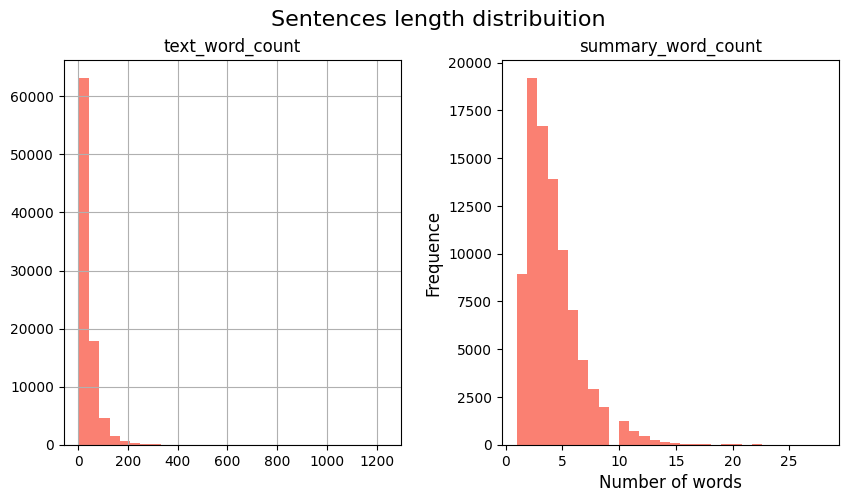

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the length of the text and summary
data["text_word_count"] = data["cleaned_text"].apply(lambda x: len(x.split()))
data["summary_word_count"] = data["cleaned_summary"].apply(lambda x: len(x.split()))

# Dataframe with text and summary length
length_df = data[["text_word_count", "summary_word_count"]]

# Plot
length_df.hist(bins=30, figsize=(10, 5), color=["salmon"])
plt.suptitle("Sentences length distribuition", fontsize=16)
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequence", fontsize=12)
plt.grid(False)
plt.show()

### Only select reviews and summaries that follows some constraints

In [9]:
max_text_len = 30  # Max length of text
max_summary_len = 8  # Max length of summary

# Count the number of words in text and summary
data["text_word_count"] = data["cleaned_text"].apply(
    lambda x: len(x.split())
)  # Count words in text
data["summary_word_count"] = data["cleaned_summary"].apply(
    lambda x: len(x.split())
)  # Count words in summary

# Filter only text and summaries that satisfy the length limits
filtered_data = data[
    (data["text_word_count"] <= max_text_len)
    & (data["summary_word_count"] <= max_summary_len)
]

# Creare un nuovo DataFrame con i dati filtrati
df = filtered_data[["cleaned_text", "cleaned_summary"]].rename(
    columns={"cleaned_text": "text", "cleaned_summary": "summary"}
)

# Visualize dataframe
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
6,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,great just as good as the expensive brands


### Add START and END special tokens

In [10]:
# Add special tokens to the summary if not already present
def add_special_tokens(summary_text):
    """
    Add special tokens to the summary if not already present

    Args:
        summary_text (str): Text to modify.

    Returns:
        str: Text with special tokens.
    """
    prefix = "sostok "
    suffix = " eostok"

    # Add the prefix if not already present
    if not summary_text.startswith(prefix):
        summary_text = prefix + summary_text

    # Add the suffix if not already present
    if not summary_text.endswith(suffix):
        summary_text = summary_text + suffix

    return summary_text


# Apply the function to the summary column
df["modified_summary"] = df["summary"].apply(add_special_tokens)

# Visualize
print(df["modified_summary"].head())

0                         sostok good quality dog food eostok
1                             sostok not as advertised eostok
3                                sostok cough medicine eostok
4                                   sostok great taffy eostok
6    sostok great just as good as the expensive brands eostok
Name: modified_summary, dtype: object


### Split training and validation set

In [11]:
from sklearn.model_selection import train_test_split

x_training, x_validation, y_training, y_validation = train_test_split(
    np.array(df["text"]),
    np.array(df["modified_summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

# Print the size of the training and validation set
print(f"Training set size: {len(x_training)}")
print(f"Validation set size: {len(x_validation)}")

Training set size: 42451
Validation set size: 4717


## Tokenizers

### Rarewords
Rarewords are words that occurs less than a certain amount of time in the vocabulary

In [12]:
def calculate_rare_words_coverage(tokenizer, threshold=4):
    """
    Calculate the percentage of rare words and the coverage of rare words in the vocabulary.

    Args:
        tokenizer (Tokenizer): The tokenizer object.
        threshold (int): The threshold to consider a word as rare.

    Returns:
        dict: A dictionary containing the percentage of rare words and the coverage of rare words.
    """
    cnt = 0  # Number of rare words
    tot_cnt = 0  # Number of total words
    freq = 0  # Frequency of rare words
    tot_freq = 0  # Total frequency of all words

    for key, value in tokenizer.word_counts.items():
        tot_cnt += 1
        tot_freq += value
        if value < threshold:
            cnt += 1
            freq += value

    # Percentage of rare words
    rare_word_percentage = (cnt / tot_cnt) * 100 if tot_cnt > 0 else 0
    rare_word_coverage = (freq / tot_freq) * 100 if tot_freq > 0 else 0

    return {
        "percentage_of_rare_words": rare_word_percentage,
        "coverage_of_rare_words": rare_word_coverage,
        "cnt": cnt,
        "tot_cnt": tot_cnt,
        "freq": freq,
        "tot_freq": tot_freq,
    }



### Text-Tokenizer

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_training))

# Calculate the percentage of rare words and the coverage of rare words in the vocabulary
x_rarewords_result = calculate_rare_words_coverage(x_tokenizer, threshold=4)

# Print the result
print(f"% of rare words in vocabulary: {x_rarewords_result['percentage_of_rare_words']:.2f}%")
print(f"Total Coverage of rare words: {x_rarewords_result['coverage_of_rare_words']:.2f}%")

# Define the maximum vocabulary size
max_vocab_size = max(x_rarewords_result["tot_cnt"] - x_rarewords_result["cnt"], 1)

# Define the tokenizer with the maximum vocabulary size
x_tokenizer = Tokenizer(num_words=max_vocab_size)

# Fit the tokenizer on the training data
x_tokenizer.fit_on_texts(list(x_training))

# Calculate the percentage of rare words and the coverage of rare words in the vocabulary
x_tr_seq = x_tokenizer.texts_to_sequences(x_training)
x_val_seq = x_tokenizer.texts_to_sequences(x_validation)

# Pad the sequences
x_training_padded = pad_sequences(x_tr_seq, maxlen=max_text_len, padding="post")
x_validation_padded = pad_sequences(x_val_seq, maxlen=max_text_len, padding="post")

# Define the vocabulary size (padding token included)
x_voc = x_tokenizer.num_words + 1

# Print the vocabulary size
print(f"Vocabulary dimension (padding token included (+1)): {x_voc}")

% of rare words in vocabulary: 66.08%
Total Coverage of rare words: 2.94%
Vocabulary dimension (padding token included (+1)): 8430


### Summary-Tokenizer

In [14]:
# prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_training))

# Calculate the percentage of rare words and the coverage of rare words in the vocabulary
y_rarewords_result = calculate_rare_words_coverage(y_tokenizer, threshold=6)

# Print the result
print(f"% of rare words in vocabulary: {y_rarewords_result['percentage_of_rare_words']:.2f}%")
print(f"Total Coverage of rare words: {y_rarewords_result['coverage_of_rare_words']:.2f}%")

# Define the maximum vocabulary size
max_vocab_size = max(y_rarewords_result["tot_cnt"] - y_rarewords_result["cnt"], 1)

# Define the tokenizer with the maximum vocabulary size
y_tokenizer = Tokenizer(num_words=max_vocab_size)

# Fit the tokenizer on the training data
y_tokenizer.fit_on_texts(list(y_training))

# Calculate the percentage of rare words and the coverage of rare words in the vocabulary
y_tr_seq = y_tokenizer.texts_to_sequences(y_training)
y_val_seq = y_tokenizer.texts_to_sequences(y_validation)

# Pad the sequences
y_training_padded = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding="post")
y_validation_padded = pad_sequences(y_val_seq, maxlen=max_summary_len, padding="post")

# Define the vocabulary size (padding token included)
y_voc = y_tokenizer.num_words + 1

# Print the vocabulary size
print(f"Vocabulary dimension (padding token included (+1)): {y_voc}")


% of rare words in vocabulary: 78.26%
Total Coverage of rare words: 5.41%
Vocabulary dimension (padding token included (+1)): 1975


#### Remove rows containing only the start and end tokens

In [15]:
# Function to determine wether a sequence contains only START and END tokens
def is_only_start_end(sequence):
    return np.count_nonzero(sequence) == 2  # Count the number of non-zero elements, if only 2 then delete

# Create a mask to remove sequences that contain only START and END tokens
mask_training = [not is_only_start_end(seq) for seq in y_training_padded]
mask_validation = [not is_only_start_end(seq) for seq in y_validation_padded]

# Apply the mask to the training and validation data
x_training_padded = x_training_padded[mask_training]
y_training_padded = y_training_padded[mask_training]
x_validation_padded = x_validation_padded[mask_validation]
y_validation_padded = y_validation_padded[mask_validation]


# Verify the shape of the training and validation data
print(f"x_training shape: {x_training_padded.shape}")
print(f"y_training shape: {y_training_padded.shape}")
print(f"x_validation shape: {x_validation_padded.shape}")
print(f"y_validation shape: {y_validation_padded.shape}")


x_training shape: (41326, 30)
y_training shape: (41326, 8)
x_validation shape: (4594, 30)
y_validation shape: (4594, 8)


## Model

Il modello è Seq2Seq con attention, utilizzando LSTM come encoder e decoder. Inoltre, il modello utilizza un layer di attenzione (customizzato con AttentionLayer)

I0000 00:00:1734282476.610070    9408 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5863 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "bohmodel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder-Input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder-Input       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder-Embedding   │ (None, 30, 100)   │    843,000 │ Encoder-Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 30)        │          0 │ Encoder-Input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder-Embedding   │ (None, 7, 100)    │    197,500 │ Decoder-Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder-LSTM (LSTM) │ [(None, 512),     │  1,255,424 │ Encoder-Embeddin… │
│                     │ (None, 512),      │            │ not_equal_2[0][0] │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder-LSTM (LSTM) │ [(None, 7, 512),  │  1,255,424 │ Decoder-Embeddin… │
│                     │ (None, 512),      │            │ Encoder-LSTM[0][… │
│                     │ (None, 512)]      │            │ Encoder-LSTM[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output-Dense        │ (None, 7, 1975)   │  1,013,175 │ Decoder-LSTM[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,564,523 (17.41 MB)

 Trainable params: 4,564,523 (17.41 MB)

 Non-trainable params: 0 (0.00 B)

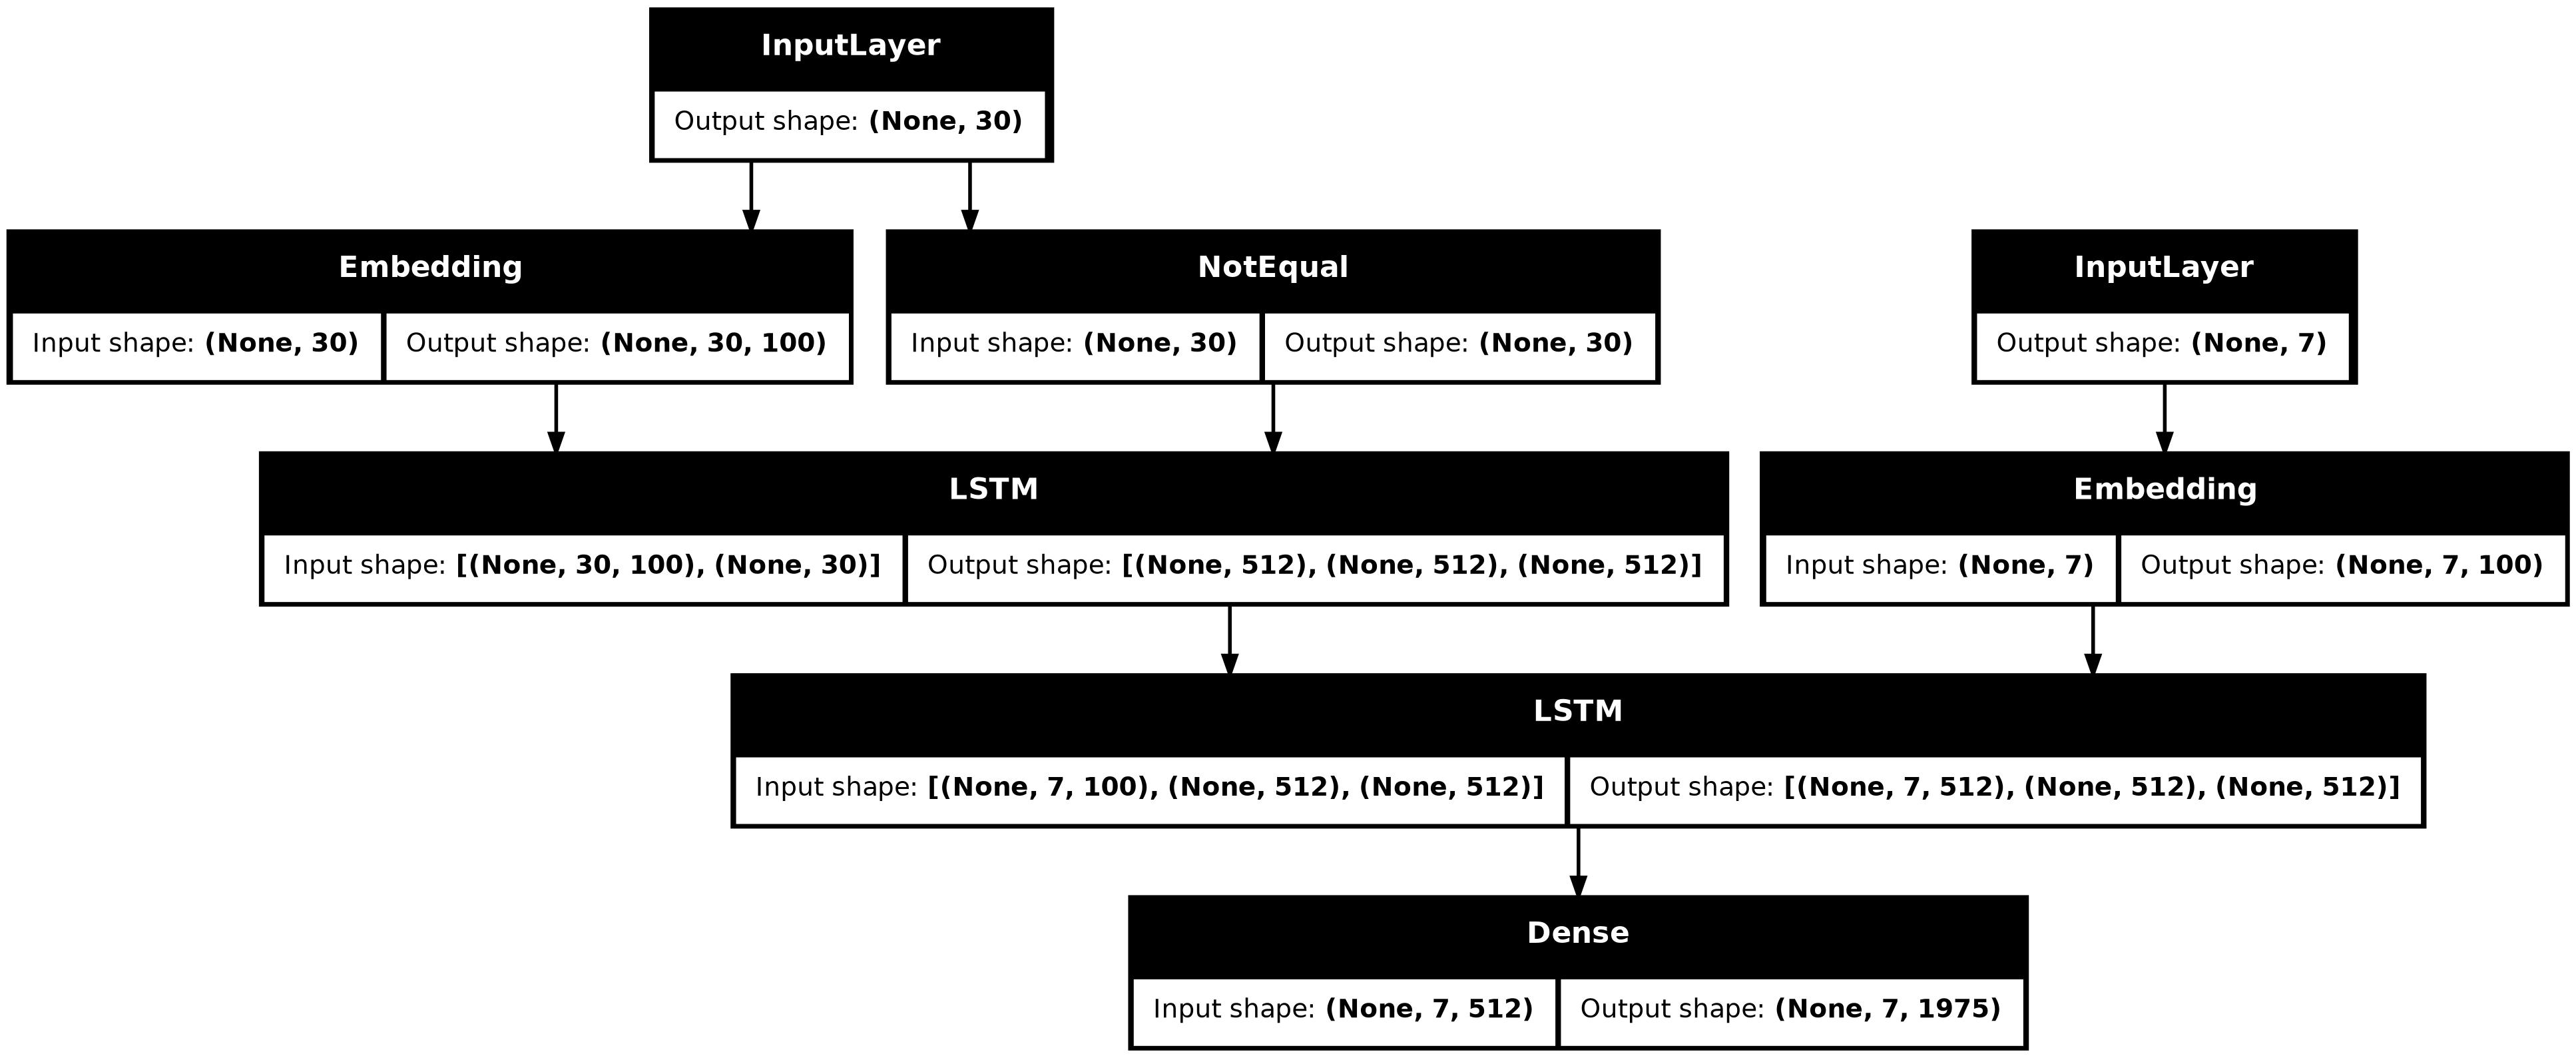

In [ ]:
from keras import backend as K
from keras.utils import plot_model

K.clear_session()

from architectures.Seq2SeqLSTM import Seq2SeqLSTM
from architectures.model import bohmodel

# Define the model
model = Seq2SeqLSTM(x_voc, y_voc, max_text_len, max_summary_len)
#model = bohmodel(x_voc, y_voc, max_text_len, max_summary_len - 1)

model = model.get_model()

model.summary()

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
plot_model(model, to_file=f"results/{model.name}_image.png", show_shapes=True)

## Training

In [17]:
early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=2, restore_best_weights=True
)  # early stopping

history = model.fit(
    [x_training_padded, y_training_padded[:, :-1]],
    y_training_padded.reshape(y_training_padded.shape[0], y_training_padded.shape[1], 1)[:, 1:],
    epochs=2,
    callbacks=[early_stopping],
    batch_size=128,
    validation_data=(
        [x_validation_padded, y_validation_padded[:, :-1]],
        y_validation_padded.reshape(y_validation_padded.shape[0], y_validation_padded.shape[1], 1)[:, 1:],
    ),
)  # training


Epoch 1/2


I0000 00:00:1734282485.958790    9497 cuda_dnn.cc:529] Loaded cuDNN version 90300


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 4.5934 - val_loss: 3.8901
Epoch 2/2
323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.8557 - val_loss: 3.7356
Restoring model weights from the end of the best epoch: 2.


## Plot

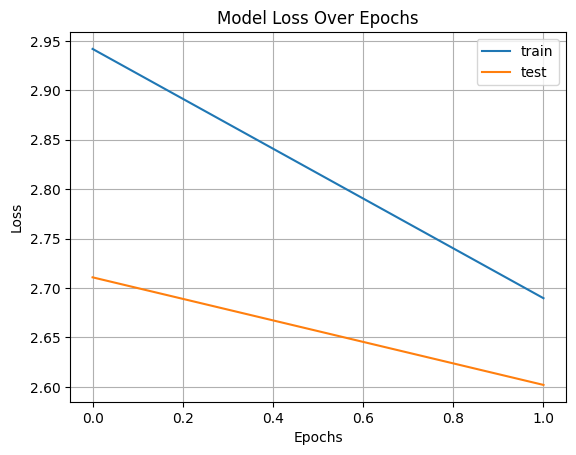

In [ ]:
from matplotlib import pyplot as plt

# Plot training and validation loss
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

# Save the plot to a file
plt.savefig(f"results/{model.name}_lossplot", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

## Inference

In [ ]:
# Build the dictionary to convert the index to word for target and source vocabulary
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
)




# Encode the input sequence to get the feature vector
encoder_model = Model(
    inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c]
)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# attention inference
attn_out_inf, attn_states_inf = attn_layer(
    [decoder_hidden_state_input, decoder_outputs2]
)
decoder_inf_concat = Concatenate(axis=-1, name="concat")(
    [decoder_outputs2, attn_out_inf]
)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs]
    + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2],
)


# Inference function
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index["sostok"]

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != "eostok":
            decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop word.
        if sampled_token == "eostok" or len(decoded_sentence.split()) >= (
            max_summary_len - 1
        ):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


def seq2summary(input_seq):
    newString = ""
    for i in input_seq:
        if (i != 0 and i != target_word_index["sostok"]) and i != target_word_index[
            "eostok"
        ]:
            newString = newString + reverse_target_word_index[i] + " "
    return newString


def seq2text(input_seq):
    newString = ""
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + " "
    return newString

NameError: name 'encoder_inputs' is not defined

In [ ]:
for i in range(0, 50):
    print("Review:", seq2text(x_training_padded[i]))
    print("Original summary:", seq2summary(y_training_padded[i]))
    print("Predicted summary:", decode_sequence(x_training_padded[i].reshape(1, max_text_len)))
    print("\n")

Review: great product thanks great seller needed fall pumpkin cupcakes order later 
Original summary: orange crystal sugar 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted summary:  great


Review: loves tastes good meaty cousin eat meat miss cousin put chopped cilantro onions sour cream top good time 
Original summary: love this stuff 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted summary:  great


Review: gluten free children love dinner creamy nice flavor yr old makes brother easy definitely favorite 
Original summary: mrs creamy tuna dinner 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted summary:  great gluten free


Review: poor mother struggled irregularity life tea gives natu